In [2]:
import truth_request as tr
import truth_analysis as ta

from imp import reload

from datetime import datetime
from datetime import timedelta
from dateutil.parser import parse as date_parse

import auth
import requests
import json

import datetime as dt

import numpy as np

import statistics

In [3]:
from itertools import zip_longest

In [4]:
from matplotlib import pyplot as plt

## Initialize orekit

In [5]:
import orekit
from orekit.pyhelpers import  setup_orekit_curdir

In [6]:
orekit_vm = orekit.initVM()
setup_orekit_curdir("/Users/gkeramidas/Projects/learning/leolabs-config-data-dynamic/")

In [139]:
reload(tr)

<module 'truth_request' from '/Users/gkeramidas/Projects/learning/truth_request.py'>

In [138]:
reload(ta)

<module 'truth_analysis' from '/Users/gkeramidas/Projects/leo-backend-od/truth_analysis.py'>

## Functions for distributions

In [7]:
ILRS_targets = ['L5011', 'L3059', 'L335', 'L2486', 'L4884', 'L1471', 'L5429', 'L3972', 'L3969', 'L2669', 'L3226']

In [65]:
def collect_all_states(ILRS_target_list, epoch, dates_back_from_epoch):
    """Collects all states for a list of ILRS targets and a specified date range going back from the epoch."""
    tot_state_arr = np.empty(3,dtype='<U32')
    
    for target in ILRS_target_list:
        state_arr = tr.states_available_x_days_from_epoch(target,epoch,dates_back_from_epoch)
        if (state_arr is not None):
            tot_state_arr = np.vstack((tot_state_arr,state_arr.astype('<U32')))
        else:
            pass
        
    return tot_state_arr[1:]

In [66]:
def state_error(object_id,state_id,epoch,timestep = 150, plotting = False):
    """Creates a truth object from a state and runs truth analysis on it, returning the errors."""
    # Initializing object
    id_data_TO = tr.id_data(object_id) # Id data of a truth object
    
    start_time_str, end_time_str = tr.propagation_dates_from_epoch(epoch)
    
    
    propagations_ST = tr.propagation_of_state(object_id,state_id,start_time_str,end_time_str,timestep) # propagate the state and collect the propagations
    propagations_ST_list = tr.propagations_list(propagations_ST) # put the propagations in a container
    ric_covariances_ST = tr.RIC_covariance_of_propagations(object_id,state_id,start_time_str,end_time_str,timestep) # find the covariances of the propagations in the RIC frame
    ric_covariances_ST_list = tr.RIC_Covariances_list(ric_covariances_ST) # put the RIC covariances in a container
    TO = ta.TruthAnalysis(id_data_TO,propagations_ST_list,ric_covariances_ST_list) # Initialize a Truth Object
    
    try: # handling the exception that there are no ILRS truth files to download from S3
        norm_errors_dict, dist_list = TO.ilrs_truth_analysis() # Run Truth Analysis on the TO
        epoch_Offset = tr.extract_epochOffset(norm_errors_dict) # parse epoch Offset
        r_err = tr.extract_norm_error(norm_errors_dict,0) # parse position errors
        i_err = tr.extract_norm_error(norm_errors_dict,1)
        c_err = tr.extract_norm_error(norm_errors_dict,2)

        if plotting:
            plt.figure(figsize=(8,8))
            plt.title(f"RIC Position Error for {object_id} @ epoch {epoch}")
            plt.plot(epoch_Offset,r_err,'g',label='radial')
            plt.plot(epoch_Offset,i_err,'r',label='in-track')
            plt.plot(epoch_Offset,c_err,'b',label='cross-track')
            plt.legend(loc='upper right')
            plt.xlabel('Seconds from estimation epoch')
            plt.ylabel('Error')
            plt.show()
        return epoch_Offset, r_err, i_err, c_err
    except ValueError:
        return None, None, None, None

In [67]:
def collections_of_truth_state_errors(ILRS_target_list, epoch, days_from_epoch):
    """Collects all errors for a given list of ILRS targets and dates and returns them in the form of distributions."""
    
    state_array = collect_all_states(ILRS_target_list, epoch, days_from_epoch) # collecting all states for the specified date range
    
    num_of_states = state_array.shape[0]

    r_err_list = []
    i_err_list = []
    c_err_list = []
    Ep_Offset_list = []

    for i in range(num_of_states): # perform truth analysis on each state and store the errors
        obj_id = state_array[i][0]
        state_id = state_array[i][1]
        timestamp = state_array[i][2]

        epoch_Offset, r_err, i_err, c_err = state_error(obj_id,state_id,timestamp)
        
        if (r_err is not None):
            Ep_Offset_list.append(epoch_Offset)
            r_err_list.append(r_err)
            i_err_list.append(i_err)
            c_err_list.append(c_err)

        else: 
            pass   
        # convert the lists of errors with len = number_of_time_steps to lists of lists of the same length 
        # but each entry is a list with all the errors of that time step.
        r_err_collection = list(zip_longest(*r_err_list)) 
        i_err_collection = list(zip_longest(*i_err_list))
        c_err_collection = list(zip_longest(*c_err_list))
   
    return Ep_Offset_list[0], r_err_collection, i_err_collection, c_err_collection

In [68]:
def extract_std_from_error_distributions(err_collection):
    """Takes a collection of error distributions and returns the standard deviation at each time step."""
    stdevs = []
    for i in range(len(err_collection)):
        stdevs.append(statistics.pstdev(err_collection[i]))
    return stdevs

In [69]:
def count_states(ILRS_target_list, epoch, dates_back_from_epoch):
    """Returns number of states of ILRS targets in the specified date range."""
    state_array = collect_all_states(ILRS_target_list, epoch, dates_back_from_epoch)     
    num_of_states = state_array.shape[0]
    print(f"Number of states in specified range:{num_of_states}")

In [154]:
count_states(ILRS_targets, [2022,5,15],2)

Number of states in specified range:127


In [148]:
arr = collect_all_states(ILRS_targets[0:1], [2022,3,15],2)

In [149]:
num_of_states = arr.shape[0]

r_err_list = []
i_err_list = []
c_err_list = []
Ep_Offset_list = []

for i in range(num_of_states):
    obj_id=arr[i][0]
    state_id=arr[i][1]
    timestamp=arr[i][2]
    
    epoch_Offset, r_err, i_err, c_err = state_error(obj_id,state_id,timestamp)
    if (r_err is not None):
        Ep_Offset_list.append(epoch_Offset)
        r_err_list.append(r_err)
        i_err_list.append(i_err)
        c_err_list.append(c_err)
        
    else: 
        pass   
    
    r_err_collection = list(zip_longest(*r_err_list))
    i_err_collection = list(zip_longest(*i_err_list))
    c_err_collection = list(zip_longest(*c_err_list))

info Syncing ILRS truth data from S3 (25 files downloaded)
Epoch timestamp: 2022-03-13 00:09:47
Files initializing TEM: ['ilrs/22824/stella_cpf_220309_06801.dgf', 'ilrs/22824/stella_cpf_220309_06801.hts', 'ilrs/22824/stella_cpf_220309_06801.sgf', 'ilrs/22824/stella_cpf_220309_5681.dgf', 'ilrs/22824/stella_cpf_220309_5681.hts', 'ilrs/22824/stella_cpf_220310_06901.dgf', 'ilrs/22824/stella_cpf_220310_06901.hts', 'ilrs/22824/stella_cpf_220310_06901.sgf', 'ilrs/22824/stella_cpf_220310_5691.dgf', 'ilrs/22824/stella_cpf_220310_5691.hts', 'ilrs/22824/stella_cpf_220311_07001.dgf', 'ilrs/22824/stella_cpf_220311_07001.hts', 'ilrs/22824/stella_cpf_220311_07001.sgf', 'ilrs/22824/stella_cpf_220311_5701.dgf', 'ilrs/22824/stella_cpf_220311_5701.hts', 'ilrs/22824/stella_cpf_220312_07101.dgf', 'ilrs/22824/stella_cpf_220312_07101.hts', 'ilrs/22824/stella_cpf_220312_07101.sgf', 'ilrs/22824/stella_cpf_220312_5711.dgf', 'ilrs/22824/stella_cpf_220312_5711.hts', 'ilrs/22824/stella_cpf_220313_07201.dgf', 'ilrs

info Truth data reader assembled (1.5803520679473877 seconds elapsed)
info Syncing ILRS truth data from S3 (25 files downloaded)
Epoch timestamp: 2022-03-14 18:40:32
Files initializing TEM: ['ilrs/22824/stella_cpf_220310_06901.dgf', 'ilrs/22824/stella_cpf_220310_06901.hts', 'ilrs/22824/stella_cpf_220310_06901.sgf', 'ilrs/22824/stella_cpf_220310_5691.dgf', 'ilrs/22824/stella_cpf_220310_5691.hts', 'ilrs/22824/stella_cpf_220311_07001.dgf', 'ilrs/22824/stella_cpf_220311_07001.hts', 'ilrs/22824/stella_cpf_220311_07001.sgf', 'ilrs/22824/stella_cpf_220311_5701.dgf', 'ilrs/22824/stella_cpf_220311_5701.hts', 'ilrs/22824/stella_cpf_220312_07101.dgf', 'ilrs/22824/stella_cpf_220312_07101.hts', 'ilrs/22824/stella_cpf_220312_07101.sgf', 'ilrs/22824/stella_cpf_220312_5711.dgf', 'ilrs/22824/stella_cpf_220312_5711.hts', 'ilrs/22824/stella_cpf_220313_07201.dgf', 'ilrs/22824/stella_cpf_220313_07201.hts', 'ilrs/22824/stella_cpf_220313_07201.sgf', 'ilrs/22824/stella_cpf_220313_5721.dgf', 'ilrs/22824/stella

In [150]:
r_stdevs = []
i_stdevs = []
c_stdevs = []
for i in range(len(r_err_collection)):
    r_stdevs.append(statistics.pstdev(r_err_collection[i]))
    i_stdevs.append(statistics.pstdev(i_err_collection[i]))
    c_stdevs.append(statistics.pstdev(c_err_collection[i]))

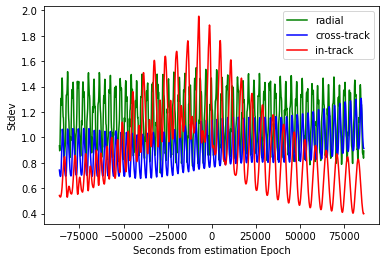

In [151]:
plt.plot(Ep_Offset_list[0],r_stdevs,"g",label="radial")
plt.plot(Ep_Offset_list[0],c_stdevs,"b",label="cross-track")
plt.plot(Ep_Offset_list[0],i_stdevs,"r",label="in-track")
plt.xlabel("Seconds from estimation Epoch")
plt.ylabel("Stdev")
plt.legend()
plt.show()

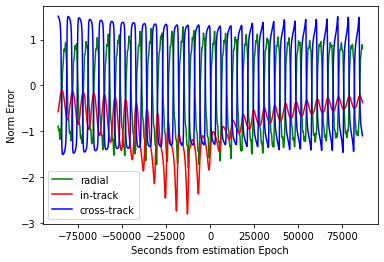

In [20]:
state_num = 40
plt.plot(Ep_Offset_list[0],[r_err_collection[i][state_num] for i in range(len(r_err_collection))],"g",label="radial")
plt.plot(Ep_Offset_list[0],[i_err_collection[i][state_num] for i in range(len(r_err_collection))],"r",label="in-track")
plt.plot(Ep_Offset_list[0],[c_err_collection[i][state_num] for i in range(len(r_err_collection))],"b",label="cross-track")
plt.xlabel("Seconds from estimation Epoch")
plt.ylabel("Norm Error")
plt.legend()
plt.show()

## Culling Outliers

In [143]:
def z_score(d,MAD):
    return 0.6745*d/MAD

def cull_outliers(arr):
    threshold = 3.0

    arr = np.array(arr)

    # Strip nans
    arr = arr[~np.isnan(arr)]

    diffs = np.sqrt((arr - np.median(arr))**2)

    MAD = np.median(diffs)

    return [y for x,y in zip(diffs,arr) if z_score(x,MAD) < threshold]

In [152]:
r_stdevs_clean = []
i_stdevs_clean = []
c_stdevs_clean = []
for i in range(len(r_err_collection)):
    r_stdevs_clean.append(statistics.pstdev(cull_outliers(r_err_collection[i])))
    i_stdevs_clean.append(statistics.pstdev(cull_outliers(i_err_collection[i])))
    c_stdevs_clean.append(statistics.pstdev(cull_outliers(c_err_collection[i])))

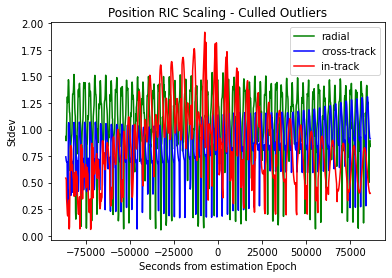

In [153]:
plt.plot(Ep_Offset_list[0],r_stdevs_clean,"g",label="radial")
plt.plot(Ep_Offset_list[0],c_stdevs_clean,"b",label="cross-track")
plt.plot(Ep_Offset_list[0],i_stdevs_clean,"r",label="in-track")
plt.xlabel("Seconds from estimation Epoch")
plt.ylabel("Stdev")
plt.title("Position RIC Scaling - Culled Outliers")
plt.legend()
plt.show()

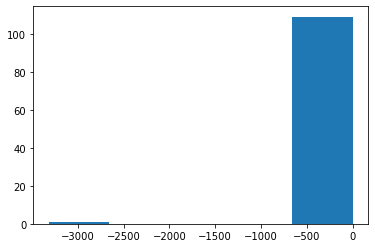

In [709]:
plt.hist(r_err_collection[1000],bins=5)
plt.show()

In [573]:
Ep_Offset_list[0]

[-86400.0, -57600.0, -28800.0, 0.0, 28800.0, 57600.0, 86400.0]

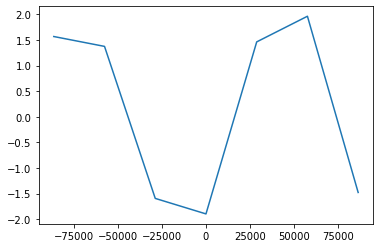

In [577]:
plt.plot(Ep_Offset_list[0],r_err_list[3])
plt.show()

In [537]:
reload(tr)

<module 'truth_request' from '/Users/gkeramidas/Projects/learning/truth_request.py'>

In [539]:
A = tr.states_available_x_days_from_epoch('L3058',[2022,2,8],2)

In [543]:
print(A)

None


info Syncing ILRS truth data from S3 (15 files downloaded)
info Truth data reader assembled (1.0642719268798828 seconds elapsed)
length= 7


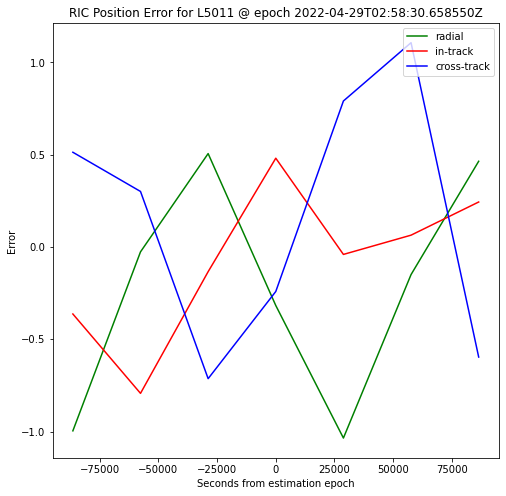

In [453]:
state_error('L5011','22047884', '2022-04-29T02:58:30.658550Z',28800)

## Make the API request of a truth object and set up properly a truth analysis object from it

In [408]:
# Input data
object_id = 'L5011'
start_date = [2022,5,27] # start date of states and propagations
end_date = [2022,5,30] # end date of propagations
timestep = 150 # timestep in seconds

In [409]:
id_data_L5011 = tr.id_data(object_id)

In [410]:
SD = tr.state_data(object_id,start_date,end_date)
ST0_ID = str(SD.json()["states"][0]["id"]) # Simply pick the first state from the list of states

In [411]:
SD.json()["states"][0]["timestamp"]

'2022-05-27T00:15:37.322892Z'

In [412]:
date_before = date_parse(SD.json()["states"][0]["timestamp"],ignoretz=True) - timedelta(seconds=86399)

In [413]:
str_date_before = date_before.strftime("%Y-%m-%dT%H:%M:%SZ")

In [414]:
str_date_before

'2022-05-26T00:15:38Z'

In [415]:
date_parse(SD.json()["states"][0]["timestamp"],ignoretz=True)

datetime.datetime(2022, 5, 27, 0, 15, 37, 322892)

In [272]:
SD.json()["states"][0]

{'id': 19503682,
 'catalogNumber': 'L5011',
 'noradCatalogNumber': 22824,
 'updatedAt': '2022-02-03T00:28:44.938953Z',
 'createdAt': '2022-02-03T00:28:44.938960Z',
 'timestamp': '2022-02-03T00:19:18.612901Z',
 'source': 'leolabs',
 'propagations': {'available': True,
  'startTime': '2022-02-02T00:19:18.612901Z',
  'endTime': '2022-02-10T00:19:18.612901Z'},
 'frames': {'EME2000': {'position': [4588827.430593419,
    5409814.282536639,
    1138983.3381780402],
   'velocity': [145.698137112531, -1664.690929760702, 7258.277997225527],
   'covarianceExtended': [[309.04113060922816,
     -255.21297781463838,
     -18.693576034519253,
     -0.09643862254053183,
     0.016022733917165424,
     0.0031088823107664532,
     4.337314595153644e-06,
     0.0009128770325140572],
    [-255.21297781463838,
     605.2916707170955,
     -1837.547323832587,
     1.431952270794579,
     1.5964158406748146,
     0.3372449364751866,
     -8.033788316184627e-05,
     -0.000873017482297166],
    [-18.693576034

In [416]:
str_date_before

'2022-05-26T00:15:38Z'

In [417]:
propagation_url = "".join([auth.api_url, '/catalog/objects/',object_id,'/states/',ST0_ID,'/propagations?startTime=',str_date_before,'&endTime=','2022-05-29T00:00:00Z','&timestep=',str(timestep)])
    
propagation_response = requests.get(propagation_url, headers=auth.headers)

In [291]:
propagation_response.json()

{'propagation': [{'timestamp': '2022-02-02T00:19:19Z',
   'position': [-566400.506450159, 1085439.679422521, -7081331.049793028],
   'velocity': [4815.31777936811, 5648.168788779039, 475.9060635792227],
   'covariance': [[3536.5569125744846,
     4157.28601599131,
     373.88625071586137,
     0.42738101266823153,
     -0.8467959959613457,
     6.050157021830189],
    [4157.28601599131,
     4901.50580461712,
     440.23550691849994,
     0.434896213527747,
     -0.9421681793737186,
     7.138110703677257],
    [373.88625071586137,
     440.23550691849994,
     46.9640478364017,
     0.03935791720516355,
     -0.07452105359548782,
     0.6419421151812209],
    [0.42738101266823153,
     0.434896213527747,
     0.03935791720516355,
     0.0003751258792479374,
     -0.00036143392287599815,
     0.0006079381531320146],
    [-0.8467959959613457,
     -0.9421681793737186,
     -0.07452105359548783,
     -0.00036143392287599815,
     0.00042494779109660815,
     -0.0013504631468789744],
    

In [418]:
propagations_L5011_ST0_list = tr.propagations_list(propagations_L5011_ST0) # put the propagations in a container

In [419]:
ric_covariances_L5011_ST0 = tr.RIC_covariance_of_propagations(object_id,ST0_ID,start_date,end_date,timestep) # find the covariances of the propagations in the RIC frame

TypeError: sequence item 6: expected str instance, list found

In [82]:
ric_covariances_L5011_ST0_list = tr.RIC_Covariances_list(ric_covariances_L5011_ST0) # put the RIC covariances in a container

In [99]:
t0 = propagations_L5011_ST0_list[0].timestamp.strftime("%Y-%m-%d")

## Initialize a truth analysis object

In [83]:
L5011_TO = ta.TruthAnalysis(id_data_L5011,propagations_L5011_ST0_list,ric_covariances_L5011_ST0_list)

In [84]:
norm_errors_dict7d, dist_list7d = L5011_TO.ilrs_truth_analysis()

info Syncing ILRS truth data from S3 (17 files downloaded)
info Truth data reader assembled (1.097383975982666 seconds elapsed)


In [61]:
epoch_Offset = extract_epochOffset(norm_errors_dict)

In [49]:
epoch_Offset2 = extract_epochOffset(norm_errors_dict)

In [85]:
epoch_Offset7d = extract_epochOffset(norm_errors_dict7d)

In [62]:
r_err = extract_norm_error(norm_errors_dict,0)
i_err = extract_norm_error(norm_errors_dict,1)
c_err = extract_norm_error(norm_errors_dict,2)

In [50]:
r_err2 = extract_norm_error(norm_errors_dict,0)
i_err2 = extract_norm_error(norm_errors_dict,1)
c_err2 = extract_norm_error(norm_errors_dict,2)

In [86]:
r_err7d = extract_norm_error(norm_errors_dict7d,0)
i_err7d = extract_norm_error(norm_errors_dict7d,1)
c_err7d = extract_norm_error(norm_errors_dict7d,2)

In [87]:
print(len(epoch_Offset))
print(len(epoch_Offset2))
print(len(epoch_Offset7d))
print(len(r_err))
print(len(r_err2))
print(len(r_err7d))

173
1729
173
173
1729
173


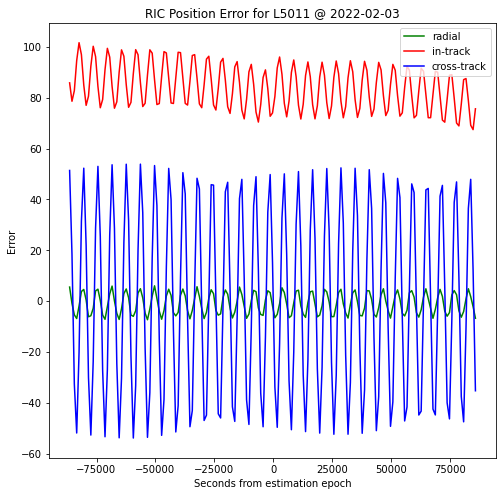

In [100]:
plt.figure(figsize=(8,8))
plt.title(f"RIC Position Error for {object_id} @ {t0}")
plt.plot(epoch_Offset,r_err,'g',label='radial')
plt.plot(epoch_Offset,i_err,'r',label='in-track')
plt.plot(epoch_Offset,c_err,'b',label='cross-track')
plt.legend(loc='upper right')
plt.xlabel('Seconds from estimation epoch')
plt.ylabel('Error')
plt.show()

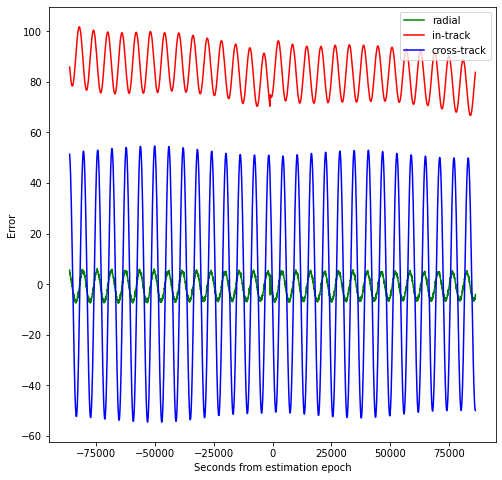

In [51]:
plt.figure(figsize=(8,8))
plt.plot(epoch_Offset2,r_err2,'g',label='radial')
plt.plot(epoch_Offset2,i_err2,'r',label='in-track')
plt.plot(epoch_Offset2,c_err2,'b',label='cross-track')
plt.legend(loc='upper right')
plt.xlabel('Seconds from estimation epoch')
plt.ylabel('Error')
plt.show()

In [89]:
len(dist_list)

173

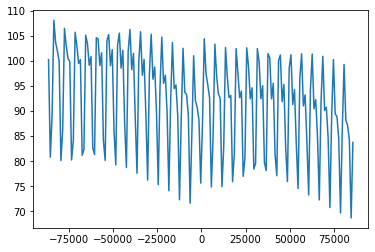

In [90]:
plt.plot(epoch_Offset,dist_list)
plt.show()

In [163]:
# Input data
object_id_new = 'L2682'
start_date_new = [2022,2,12] # start date of states and propagations
end_date_new = [2022,2,19] # end date of propagations
state_position_new = 2 # position of state in the range of dates
timestep_new = 150 # timestep in seconds

info Syncing ILRS truth data from S3 (16 files downloaded)
info Truth data reader assembled (1.692302942276001 seconds elapsed)


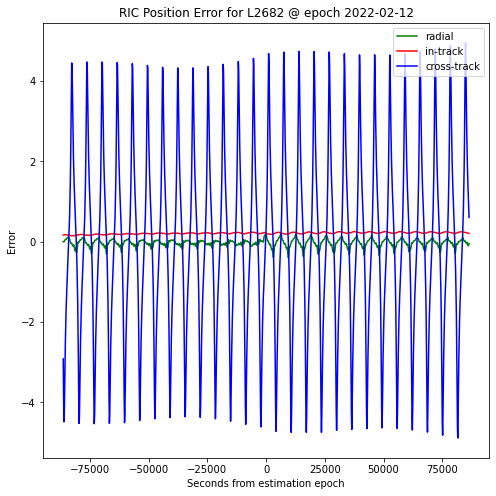

In [164]:
state_error(object_id_new,start_date_new,end_date_new,state_position_new,timestep_new)

## Make script for downloading all truth files from AWS belonging to certain dates

In [35]:
from utilities.aws_helper import AwsHelper
from utilities.api import Api
from utilities.od_logging import OptionalLog

In [36]:
import re
import os
import time
import shutil

In [37]:
from datetime import timezone

In [38]:
def aws_init(logger=None):
    
    # Initialize API connection object
    api_client = Api.get_client(logger=logger)

    # Initialize AWS helper functions
    aws_helper = AwsHelper(logger=logger)
    
    return api_client, aws_helper 

In [39]:
api_client, aws_helper = aws_init()

In [40]:
def set_up_truth_directory_for_target(leolabs_id):
    """Prepares a local directory for storing ILRS truth files for particular ILRS target."""
    try:
        shutil.rmtree('truth/' + str(leolabs_id)) # Remove target's directory if it already exists
    except FileNotFoundError:
        pass

    base_truth_directory = 'truth/'
    try:
        os.mkdir(base_truth_directory)
    except OSError:
        pass

    truth_directory = base_truth_directory + str(leolabs_id)
    try:
        os.mkdir(truth_directory)
    except OSError:
        pass

    return truth_directory

In [41]:
def get_truth_file_list(epoch_date, norad_id, num_days):
    """Builds list of S3 truth files for the current object that match the date range of interest."""
    
    epoch_date_in_dt = datetime(epoch_date[0],epoch_date[1],epoch_date[2]) # we need this date in datetime
    
    def string_from_date(dt):
        return str(dt.year)[-2:] + '%02d' % (dt.month,) + '%02d' % (dt.day,)

    dates_of_interest = [(epoch_date_in_dt - timedelta(days=i)) for i in range(num_days)]
    strings_of_interest = [string_from_date(d) for d in dates_of_interest]

    regex_date_matcher = re.compile(r"^.*_(\d{6})_.*\.\w{3}")
    filenames_of_interest = []

    for name in aws_helper.get_list_of_files_s3('leolabs-calibration-sources-test', 'ilrs/'+str(norad_id)): # at this stage no other bucket is required
        try:
            date_component = regex_date_matcher.match(name).group(1)

            if date_component in strings_of_interest:
                filenames_of_interest.append(name)

        except AttributeError:
            pass

    return filenames_of_interest

In [42]:
def download_truth_files(filenames, truth_directory):
    """Downloads truth files from S3 for the current truth target."""

    def date_from_string(dt_string):
        return datetime(2000+int(dt_string[0:2]), int(dt_string[2:4]), int(dt_string[4:6]))

    regex_date_matcher = re.compile(r"^.*_(\d{6})_.*\.\w{3}")
    regex_file_matcher = re.compile(r"^.*/.*/(.*)$")

    # Download most recent 5 days
    num_new_files = 0
    for name in filenames:
        filename = regex_file_matcher.match(name).group(1)

        if not os.path.isfile(truth_directory + '/' + filename):
            aws_helper.download_s3('leolabs-calibration-sources-test', name, truth_directory + '/' + filename)
            num_new_files += 1

    print('info', 'Syncing ILRS truth data from S3 ({} files downloaded)'.format(num_new_files))

    
    # Compose truth data source
    #path = ''.join([truth_directory, '/'])
    #
    #non_hidden_filelist = [] # leave out hidden files
    #for f in os.listdir(path):
    #    if not f.startswith("."):
    #        non_hidden_filelist.append(f)
    #    
    #files = [''.join([path, filename]) for filename in non_hidden_filelist]

    #return files

In [43]:
def dwld_data_for_target(leolabs_id,epoch_date,num_days):
    norad_id = tr.id_data(leolabs_id)["norad_id"] # look up norad id of target
    trth_dir = set_up_truth_directory_for_target(leolabs_id) # create directory for target
    trth_flnms = get_truth_file_list(epoch_date, norad_id, num_days) # collect all filenames to be downloaded
    download_truth_files(trth_flnms,trth_dir) # download all files

In [44]:
def dwld_data_for_all_targets(target_list,epoch,num_days):
    for target in target_list:
        dwld_data_for_target(target,epoch,num_days)

In [89]:
ILRS_targets = ['L5011', 'L3059', 'L335', 'L2486', 'L4884', 'L1471', 'L5429', 'L3972', 'L3969', 'L2669', 'L3226']

In [786]:
dwld_data_for_target('L5011',[2022,3,15],10)

info Syncing ILRS truth data from S3 (48 files downloaded)


In [56]:
dwld_data_for_target('L5011',[2022,3,15],10)

info Syncing ILRS truth data from S3 (48 files downloaded)


In [133]:
ID_dict = tr.id_data('L2486')

In [134]:
tr_flnms = get_truth_file_list([2022,3,15],ID_dict['norad_id'],2)

In [135]:
tr_flnms

['ilrs/27944/larets_cpf_220314_07301.dgf',
 'ilrs/27944/larets_cpf_220314_07301.hts',
 'ilrs/27944/larets_cpf_220314_07301.sgf',
 'ilrs/27944/larets_cpf_220314_5731.dgf',
 'ilrs/27944/larets_cpf_220314_5731.hts',
 'ilrs/27944/larets_cpf_220314_5731.mcc',
 'ilrs/27944/larets_cpf_220315_07401.dgf',
 'ilrs/27944/larets_cpf_220315_07401.hts',
 'ilrs/27944/larets_cpf_220315_07401.sgf',
 'ilrs/27944/larets_cpf_220315_5741.dgf',
 'ilrs/27944/larets_cpf_220315_5741.hts',
 'ilrs/27944/larets_cpf_220315_5741.mcc']

In [766]:
tr_dir = set_up_truth_directory_for_target('L5011')

In [770]:
tr_dir

'truth/L5011'

In [780]:
download_truth_files(tr_flnms,tr_dir,2)

info Syncing ILRS truth data from S3 (0 files downloaded)


['truth/L5011/stella_cpf_220511_13101.hts',
 'truth/L5011/stella_cpf_220512_13201.sgf',
 'truth/L5011/stella_cpf_220511_13101.dgf',
 'truth/L5011/stella_cpf_220512_13201.hts',
 'truth/L5011/stella_cpf_220511_13101.sgf',
 'truth/L5011/stella_cpf_220512_13201.dgf']

In [778]:
for f in os.listdir(tr_dir): 
    if not f.startswith("."):
        print(f)

stella_cpf_220511_13101.hts
stella_cpf_220512_13201.sgf
stella_cpf_220511_13101.dgf
stella_cpf_220512_13201.hts
stella_cpf_220511_13101.sgf
stella_cpf_220512_13201.dgf


## Plotting covariances of individual states

In [155]:
candidate_state_array = tr.states_available_x_days_from_epoch('L5011',[2022,5,15],2)

In [183]:
start_time_str, end_time_str = tr.propagation_dates_from_epoch(candidate_state_array[1,2])

In [184]:
propagations_ST = tr.propagation_of_state(candidate_state_array[1,0],candidate_state_array[1,1],start_time_str,end_time_str,timestep=150)

In [164]:
propagations_ST_list = tr.propagations_list(propagations_ST)

In [185]:
ric_covariances_ST = tr.RIC_covariance_of_propagations(candidate_state_array[1,0],candidate_state_array[1,1],start_time_str,end_time_str,timestep=150)

In [186]:
ric_covariances_ST_list = tr.RIC_Covariances_list(ric_covariances_ST)

In [187]:
propagations_ST_list[0].timestamp

datetime.datetime(2022, 5, 12, 7, 55, 50)

In [175]:
ric_covariances_ST_list[0][0][0]

54.89696168201921

In [211]:
propagations_ST_list[0].position

[4747140.779853546, -3286306.2432906297, -4271605.436353422]

In [188]:
r_cov_state = []
i_cov_state = []
c_cov_state = []
t_list = []
for i in range(len(ric_covariances_ST_list)):
    r_cov_state.append(ric_covariances_ST_list[i][0][0])
    i_cov_state.append(ric_covariances_ST_list[i][1][1])
    c_cov_state.append(ric_covariances_ST_list[i][2][2])
    t_list.append(i)

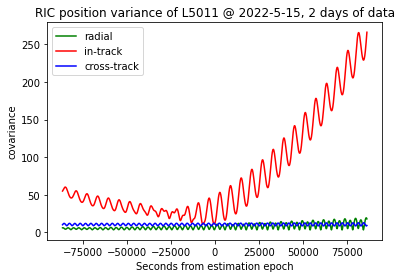

In [220]:
plt.plot(sec_list,np.sqrt(r_cov_state),'g',label='radial')
plt.plot(sec_list,np.sqrt(i_cov_state),'r',label='in-track')
plt.plot(sec_list,np.sqrt(c_cov_state),'b',label='cross-track')
plt.xlabel('Seconds from estimation epoch')
plt.ylabel('covariance')
plt.title('RIC position variance of L5011 @ 2022-5-15, 2 days of data')
#plt.ylim(0,15)
plt.legend()
plt.show()

In [198]:
rv_cov_state = []
iv_cov_state = []
cv_cov_state = []

for i in range(len(ric_covariances_ST_list)):
    rv_cov_state.append(ric_covariances_ST_list[i][3][3])
    iv_cov_state.append(ric_covariances_ST_list[i][4][4])
    cv_cov_state.append(ric_covariances_ST_list[i][5][5])

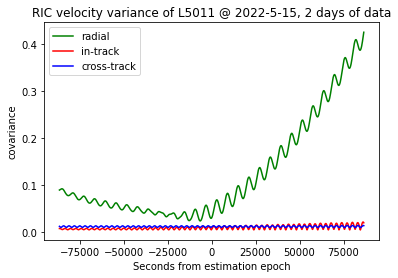

In [221]:
plt.plot(sec_list,np.sqrt(rv_cov_state),'g',label='radial')
plt.plot(sec_list,np.sqrt(iv_cov_state),'r',label='in-track')
plt.plot(sec_list,np.sqrt(cv_cov_state),'b',label='cross-track')
#plt.ylim(0,0.05)
plt.xlabel('Seconds from estimation epoch')
plt.ylabel('covariance')
plt.title('RIC velocity variance of L5011 @ 2022-5-15, 2 days of data')
plt.legend()
plt.show()

## Truth objects names

In [9]:
for target in ILRS_targets:
    target_dict = tr.id_data(target)
    print("name:", target_dict['object_name'])
    print("norad_id:", target_dict['norad_id'])
    print("leolabs_id", target_dict['leolabs_id'])

name: STELLA
norad_id: 22824
leolabs_id L5011
name: EGS (AJISAI)
norad_id: 16908
leolabs_id L3059
name: ENVISAT
norad_id: 27386
leolabs_id L335
name: LARETS
norad_id: 27944
leolabs_id L2486
name: LARES
norad_id: 38077
leolabs_id L4884
name: SARAL
norad_id: 39086
leolabs_id L1471
name: SWARM B
norad_id: 39451
leolabs_id L5429
name: SWARM A
norad_id: 39452
leolabs_id L3972
name: SWARM C
norad_id: 39453
leolabs_id L3969
name: CRYOSAT 2
norad_id: 36508
leolabs_id L2669
name: JASON 2
norad_id: 33105
leolabs_id L3226
